In [1]:
#!pip install fuzzy-c-means

In [2]:
#bibliotecas pandas de leitura de arquivos
import pandas as pd
#biblioteca do kmeans
from sklearn.cluster import KMeans
import numpy as np
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt
#caracter 
import re
#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do Random Forest
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math
from sklearn import svm
# AIX - Explanability
import lime
from lime import lime_tabular


from IPython.display import Image
from pathlib import Path

# Fuzzy C-means
#from fcmeans import FCM


In [3]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_FUZZY = DIRETORIO_PRINCIPAL / "Fuzzy"


In [4]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas

dataset = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")

#dataset = dataset.drop ("Unnamed: 0", axis=1)
#for i in dataset.columns:
#    print(repr(i))
#

In [5]:
dataset

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,data_exame,sist 9:00,sist 9:15,...,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica,Diferença % Dipping
0,4,1923-10-05,1,94.0,85.0,160,33.2,2018-09-10 12:25:23,105.0,108.0,...,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34,0.966110
1,5,1948-10-07,1,70.0,80.0,165,29.4,2018-12-26 07:39:41,103.0,114.0,...,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23,0.969464
2,6,1999-03-23,1,19.0,100.0,197,25.8,2018-12-26 08:06:19,147.0,148.0,...,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19,1.055812
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,2018-12-26 08:19:06,140.0,139.0,...,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9,1.106757
4,8,1990-03-07,1,28.0,120.0,172,40.6,2018-12-26 08:26:59,113.0,110.0,...,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11,1.136996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,21786,1972-11-25,1,47.0,75.0,165,27.5,2020-09-10 16:03:08,163.0,198.0,...,116.0,12224.5,9265.0,2439.0,474.5,18.66,14.80,49,60,1.134475
19146,21787,1970-10-19,1,49.0,90.0,183,26.9,2020-09-10 16:21:02,114.0,120.0,...,85.0,10970.0,6819.0,3319.0,738.0,17.22,13.67,32,27,1.045759
19147,21788,1985-03-15,0,35.0,93.0,167,33.3,2020-09-10 16:44:53,107.0,110.0,...,62.0,9245.0,4935.5,3556.0,713.5,14.36,8.29,14,26,1.029243
19148,21792,1952-04-21,0,68.0,64.0,160,25.0,2020-09-10 17:25:50,94.0,107.0,...,68.0,8989.5,5660.0,2815.5,460.0,14.14,9.38,19,13,1.251898


In [6]:
from typing import Optional
from pydantic import BaseModel, Extra, Field, validate_arguments


class _ArrayMeta(type):
    def __getitem__(self, t):
        return type('Array', (Array,), {'__dtype__': t})


class Array(np.ndarray, metaclass=_ArrayMeta):
    @classmethod
    def __get_validators__(cls):
        yield cls.validate_type

    @classmethod
    def validate_type(cls, val):
        dtype = getattr(cls, '__dtype__', None)
        if isinstance(val, np.ndarray):
            return val
        raise ValueError(f'{val} is not an instance of numpy.ndarray')

class FCM(BaseModel):
    n_clusters: int = Field(5, ge=1, le=100)
    max_iter: int = Field(150, ge=1, le=1000)
    m: float = Field(2.0, ge=1.0)
    error: float = Field(1e-5, ge=1e-9)
    random_state: Optional[int] = None
    trained: bool = Field(False, const=True)

    class Config:
        extra = Extra.allow
        arbitrary_types_allowed = True

    @validate_arguments
    def fit(self, X: Array[float]) -> None:
        """Train the fuzzy-c-means model..
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training instances to cluster.
        """
        self.rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]
        self.u = self.rng.uniform(size=(n_samples, self.n_clusters))
        self.u = self.u / np.tile(self.u.sum(axis=1)
                                  [np.newaxis].T, self.n_clusters)
        for _ in range(self.max_iter):
            u_old = self.u.copy()
            self._centers = FCM._next_centers(X, self.u, self.m)
            self.u = self.soft_predict(X)
            # Stopping rule
            if np.linalg.norm(self.u - u_old) < self.error:
                break
        self.trained = True

    def soft_predict(self, X: Array[float]) -> Array[float]:
        """Soft predict of FCM 
        Parameters
        ----------
        X : array, shape = [n_samples, n_features]
            New data to predict.
        Returns
        -------
        array, shape = [n_samples, n_clusters]
            Fuzzy partition array, returned as an array with n_samples rows
            and n_clusters columns.
        """
        temp = FCM._dist(X, self._centers) ** float(2 / (self.m - 1))
        denominator_ = temp.reshape(
            (X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_
        return 1 / denominator_.sum(2)

    @validate_arguments
    def predict(self, X: Array[float]):
        """Predict the closest cluster each sample in X belongs to.
        Parameters
        ----------
        X : array, shape = [n_samples, n_features]
            New data to predict.
        Returns
        -------
        labels : array, shape = [n_samples,]
            Index of the cluster each sample belongs to.
        """
        if self.is_trained():
            X = np.expand_dims(X, axis=0) if len(X.shape) == 1 else X
            return self.soft_predict(X).argmax(axis=-1)

    def is_trained(self) -> None:
        if self.trained:
            return True
        raise ReferenceError(
            "You need to train the model. Run `.fit()` method to this."
        )

    @staticmethod
    def _dist(A, B):
        """Compute the euclidean distance two matrices"""
        return np.sqrt(np.einsum("ijk->ij", (A[:, None, :] - B) ** 2))

    @staticmethod
    def _next_centers(X, u, m):
        """Update cluster centers"""
        um = u ** m
        return (X.T @ um / np.sum(um, axis=0)).T

    @property
    def centers(self):
        if self.is_trained():
            return self._centers

    @property
    def partition_coefficient(self) -> float:
        """Partition coefficient (Equation 12a of https://doi.org/10.1016/0098-3004(84)90020-7)
        Returns
        -------
        float
            partition coefficient of clustering model
        """
        if self.is_trained():
            return np.mean(self.u ** 2)

    @property
    def partition_entropy_coefficient(self):
        if self.is_trained():
            return -np.mean(self.u * np.log2(self.u))

## Inicializa K - calcula o numero de cluster

In [7]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

### Transforma Genero M = 1 e F = 0 

In [8]:
# transform Gender M and F to binary 
#
genero_M_F = {"genero": {1: "M", 0: "F"}}

In [9]:
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

In [10]:
dataset_classes_doenca = pd.DataFrame()
dataset_classes_doenca['numero_identificacao'] = dataset['numero_identificacao']
dataset_classes_doenca['genero'] = dataset['genero']
#
dataset_classes_doenca = pd.concat([dataset_classes_doenca, dataset.loc[:,'sist 9:00':'diast 8:45']],axis=1)
#
for doenca in list(dataset.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_classes_doenca[doenca] = dataset[doenca].apply(verdadeiro_falso)
dataset_classes_doenca

,numero_identificacao,genero,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,...,Hipotensao,Sistolica Isolada,Diastolica Isolada,Dipping,Non Dipping,Extreme Dipping,Reverse Dipping,Morning Surge,Masked,Whitecoat
0,4,1,105.0,108.0,116.0,104.0,106.0,98.0,102.0,107.0,...,1,0,0,0,0,0,1,0,0,0
1,5,1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,...,1,0,0,0,0,0,1,0,0,0
2,6,1,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,...,1,0,0,0,1,0,0,0,0,1
3,7,0,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,...,1,0,0,1,0,0,0,0,0,1
4,8,1,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,21786,1,163.0,198.0,172.0,148.0,161.0,156.0,156.0,138.0,...,1,0,0,1,0,0,0,1,0,1
19146,21787,1,114.0,120.0,164.0,116.0,119.0,126.0,123.0,122.0,...,1,0,0,0,1,0,0,0,0,1
19147,21788,0,107.0,110.0,103.0,105.0,108.0,111.0,114.0,144.0,...,1,0,0,0,1,0,0,0,0,1
19148,21792,0,94.0,107.0,112.0,124.0,120.0,94.0,102.0,113.0,...,1,0,0,0,0,1,0,0,0,0


In [11]:
# Dataset com cadastro, IMC e medidas
fuzzy_dataset_cadastro = pd.concat([dataset['numero_identificacao'],
                             dataset['genero'],dataset['idade'],
                             dataset['IMC'],
                             dataset.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com as medidas
fuzzi_dataset_medidas = pd.concat([dataset['numero_identificacao'],
                     dataset.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com numero identificação e estatísticas
fuzzy_dataset_estatistica = pd.concat([dataset['numero_identificacao'],
                     dataset.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']],axis=1)

# Dataset com numero identificação e doenças
fuzzy_dataset_doenca = pd.concat([dataset['numero_identificacao'],
                     dataset.loc[:,'Hipotensao':'Normotenso']],axis=1)

# Dataset apenas com pacientes do sexo masculino
fuzzy_dataset_masc = dataset[dataset['genero'] == 1]

fuzzy_dataset_masc_medidas =  pd.concat([fuzzy_dataset_masc['numero_identificacao'],
                     fuzzy_dataset_masc.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset apenas com pacientes do sexo feminino
fuzzy_dataset_fem = dataset[dataset['genero'] == 0]

fuzzy_dataset_fem_medidas =  pd.concat([fuzzy_dataset_fem['numero_identificacao'],
                     fuzzy_dataset_fem.loc[:,'sist 9:00':'diast 8:45']],axis=1)

In [12]:
print(f'Quantidade F: {len(fuzzy_dataset_fem_medidas)}\nQuantidade M: {len(fuzzy_dataset_masc_medidas)}')

Quantidade F: 10445
Quantidade M: 8705


# Abordagem 1: Cadastro e Medidas como entrada

In [13]:
fuzzy_dataset_cadastro

,numero_identificacao,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,4,1,94.0,33.2,105.0,108.0,116.0,104.0,106.0,98.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,5,1,70.0,29.4,103.0,114.0,82.0,104.0,98.0,106.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,6,1,19.0,25.8,147.0,148.0,156.0,140.0,130.0,132.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,7,0,40.0,24.2,140.0,139.0,142.0,137.0,135.0,177.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,8,1,28.0,40.6,113.0,110.0,101.0,108.0,111.0,111.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,21786,1,47.0,27.5,163.0,198.0,172.0,148.0,161.0,156.0,...,102.0,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0
19146,21787,1,49.0,26.9,114.0,120.0,164.0,116.0,119.0,126.0,...,87.0,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0
19147,21788,0,35.0,33.3,107.0,110.0,103.0,105.0,108.0,111.0,...,49.0,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0
19148,21792,0,68.0,25.0,94.0,107.0,112.0,124.0,120.0,94.0,...,63.0,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0


In [14]:
#selecionando variaveis de medidad : sist 9:00 a diast 8:45
#campos sist e diast

#   Gera uma lista com cabeçalhos
fuzzy_ls_cadastro = list(fuzzy_dataset_cadastro.loc[:,'genero':'diast 8:45'].columns)

fuzzy_cadastro_sem_id = fuzzy_dataset_cadastro.loc[:,'genero':'diast 8:45']
#dados_sist_diast = dados_sist_diast.drop(['peso','altura','data_exame'],axis=1)

fuzzy_cadastro_sem_id.head(5)

,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,1,94.0,33.2,105.0,108.0,116.0,104.0,106.0,98.0,102.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,1,70.0,29.4,103.0,114.0,82.0,104.0,98.0,106.0,108.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,1,19.0,25.8,147.0,148.0,156.0,140.0,130.0,132.0,121.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,0,40.0,24.2,140.0,139.0,142.0,137.0,135.0,177.0,148.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,1,28.0,40.6,113.0,110.0,101.0,108.0,111.0,111.0,114.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0


## Trata nulos, quando houver

In [15]:
#  ****** trocar a variável de dados_cadastro_sem_id  para  dados_cadastro_sem_nan

#dados_medidas_sem_nan = dados_medidas.fillna(0)

#  Retirar a linha que contém NaN em alguma coluna 
# dados_cadastro_sem_nan = dados_cadastro
# ls_cadastro = list(dados_cadastro_sem_nan.columns)

## Abordagem 1: Número de Clusters gerado pelo k-Means

In [16]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_cadastro = calculate_wcss(fuzzy_cadastro_sem_id)
fuzzy_num_otimo_clusters_cadastro = optimal_number_of_clusters(sum_of_squares_cadastro)
fuzzy_num_otimo_clusters_cadastro

Wall time: 1min 24s


7

In [17]:
#convertendo os dados para a clusterização
fuzzy_cadastro_array = np.array(fuzzy_cadastro_sem_id)

In [18]:
#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
#fuzzy_cadastro = KMeans(n_clusters=num_otimo_clusters_cadastro, random_state=42).fit(fuzzy_cadastro_array)

fuzzy_cadastro = FCM(n_clusters=fuzzy_num_otimo_clusters_cadastro, random_state=42)
fuzzy_cadastro.fit(fuzzy_cadastro_array)

In [19]:
fuzzy_cadastro

FCM(n_clusters=7, max_iter=150, m=2.0, error=1e-05, random_state=42, trained=True, rng=Generator(PCG64) at 0x259FC48BD68, u=array([[0.17505325, 0.1042466 , 0.17280177, ..., 0.10452307, 0.12754714,
        0.1748587 ],
       [0.20290323, 0.08145969, 0.19573598, ..., 0.08174409, 0.10836267,
        0.20226256],
       [0.11722729, 0.16656251, 0.1198106 , ..., 0.16661566, 0.16098938,
        0.11745292],
       ...,
       [0.19184956, 0.08919582, 0.18724925, ..., 0.08949539, 0.11642812,
        0.19144546],
       [0.19610695, 0.08442755, 0.19135207, ..., 0.08474669, 0.1139452 ,
        0.19569216],
       [0.13568779, 0.1433315 , 0.13742572, ..., 0.14351881, 0.15231929,
        0.13584248]]), _centers=array([[ 0.41471554, 55.39306526, 27.68662597, ..., 76.42708764,
        76.74927029, 76.97360158],
       [ 0.50667151, 55.54973244, 27.96410949, ..., 84.79892876,
        85.01647717, 85.25765242],
       [ 0.41854415, 55.41204187, 27.70664673, ..., 76.70764473,
        77.02948909, 77.

In [20]:
fuzzy_grupos_cadastro = np.array(fuzzy_cadastro.predict(fuzzy_cadastro_array)) + 1

In [21]:
#incluir grupos nos dados de sist e diast
fuzzy_cadastro_sem_id['grupo'] = fuzzy_grupos_cadastro
fuzzy_cadastro_sem_id['grupo'] = fuzzy_cadastro_sem_id['grupo'] + 1
fuzzy_cadastro_sem_id


,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,...,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45,grupo
0,1,94.0,33.2,105.0,108.0,116.0,104.0,106.0,98.0,102.0,...,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0,2
1,1,70.0,29.4,103.0,114.0,82.0,104.0,98.0,106.0,108.0,...,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0,2
2,1,19.0,25.8,147.0,148.0,156.0,140.0,130.0,132.0,121.0,...,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0,6
3,0,40.0,24.2,140.0,139.0,142.0,137.0,135.0,177.0,148.0,...,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0,3
4,1,28.0,40.6,113.0,110.0,101.0,108.0,111.0,111.0,114.0,...,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,1,47.0,27.5,163.0,198.0,172.0,148.0,161.0,156.0,156.0,...,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0,3
19146,1,49.0,26.9,114.0,120.0,164.0,116.0,119.0,126.0,123.0,...,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0,3
19147,0,35.0,33.3,107.0,110.0,103.0,105.0,108.0,111.0,114.0,...,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0,2
19148,0,68.0,25.0,94.0,107.0,112.0,124.0,120.0,94.0,102.0,...,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0,2


## Abordagem 1: O método Elbow

### Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico

### https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

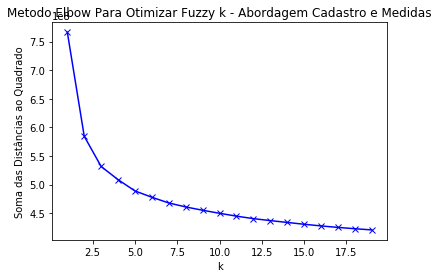

Wall time: 78.1 ms


In [22]:
#metodo de Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(fuzzy_cadastro_array)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar Fuzzy k - Abordagem Cadastro e Medidas')
fig = plt.gcf() 
fig.savefig( DIR_FUZZY / 'graficos' / f'metodoelbow_fuzzy_cadastro.svg', format="svg")
%time plt.show()

In [23]:
#fig.savefig('D:\Projeto_PA\\Projeto_PA_validado\\KMeansRandom\\graficos\\grafico_metodoelbow_medidas.svg', format='svg')
#plt.savefig(DIR_NMF / f'NMF_classificado_{grupo}.svg',format="svg")
#fig.savefig('diastolica_sistolica/diast_sist_elbow.png', format='png')


## Abordagem 1: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette médio para Fuzzy é : 0.1967686241897333
Para n_clusters = 3 O score_silhouette médio para Fuzzy é : 0.06371508125351816
Para n_clusters = 4 O score_silhouette médio para Fuzzy é : 0.03437284189424849
Para n_clusters = 5 O score_silhouette médio para Fuzzy é : 0.018437637657352148
Para n_clusters = 6 O score_silhouette médio para Fuzzy é : 0.009869665403770229
Para n_clusters = 7 O score_silhouette médio para Fuzzy é : 0.0063474156886457215
Para n_clusters = 8 O score_silhouette médio para Fuzzy é : 0.0015767692750999758


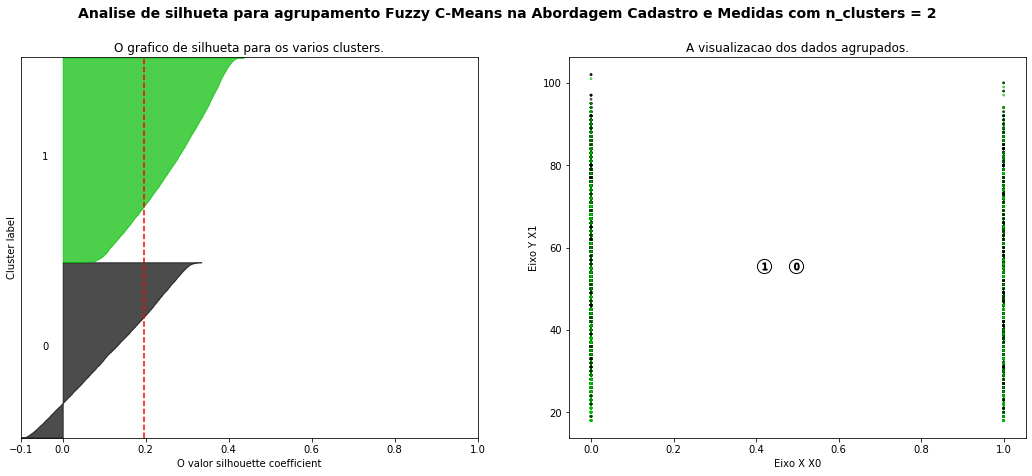

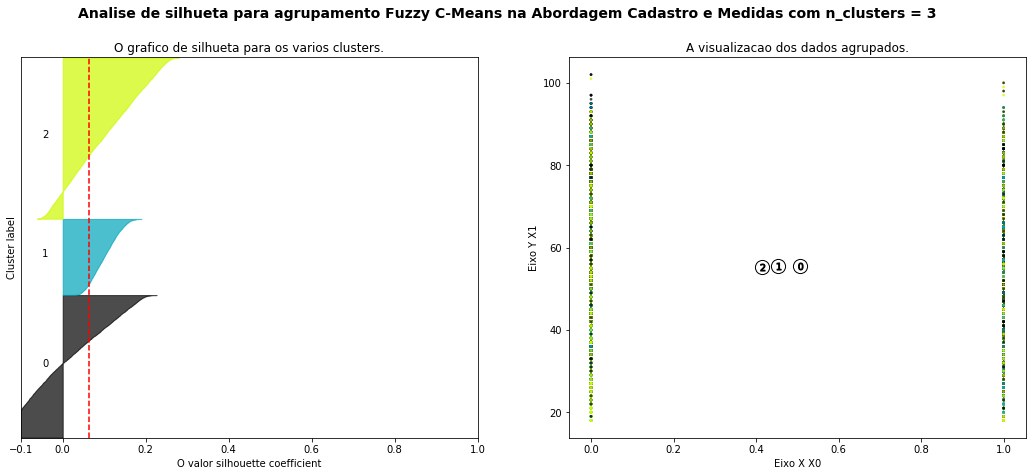

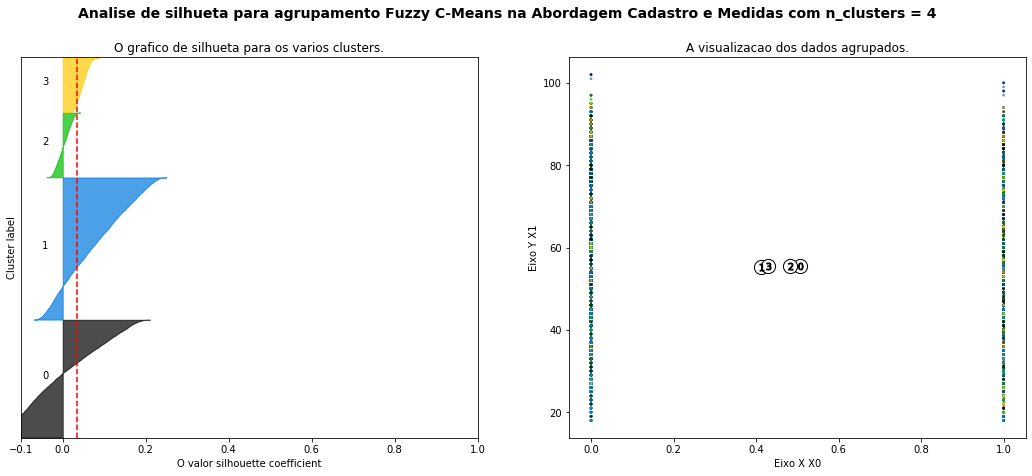

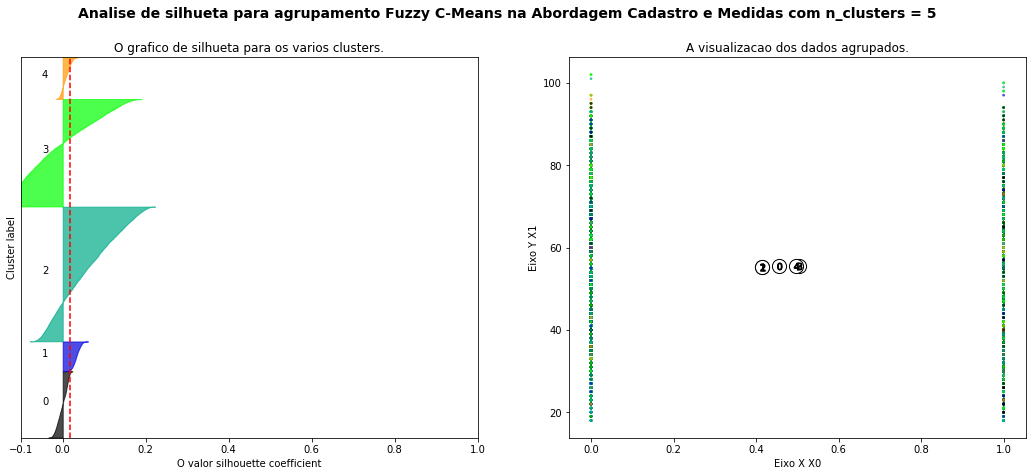

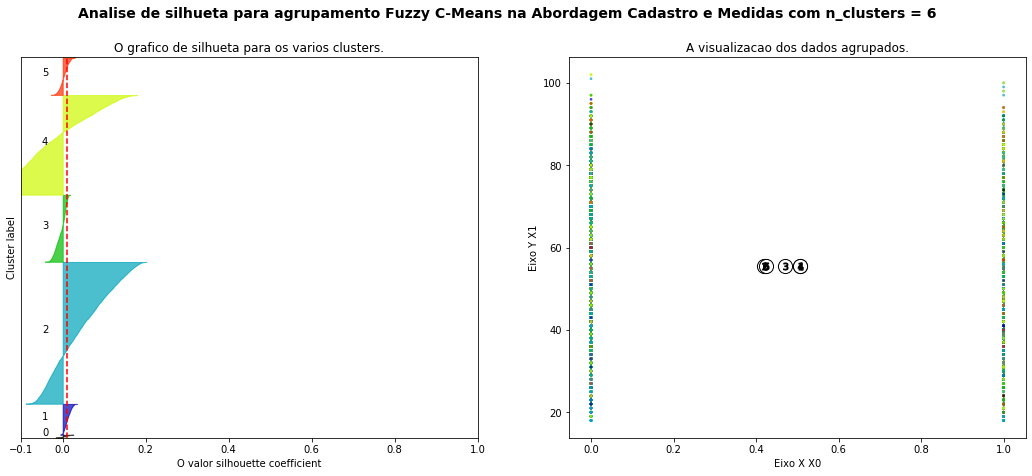

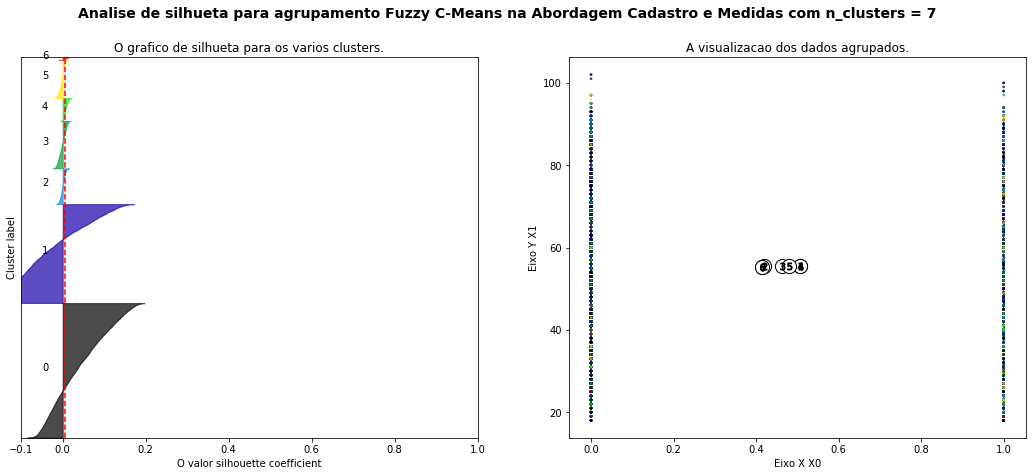

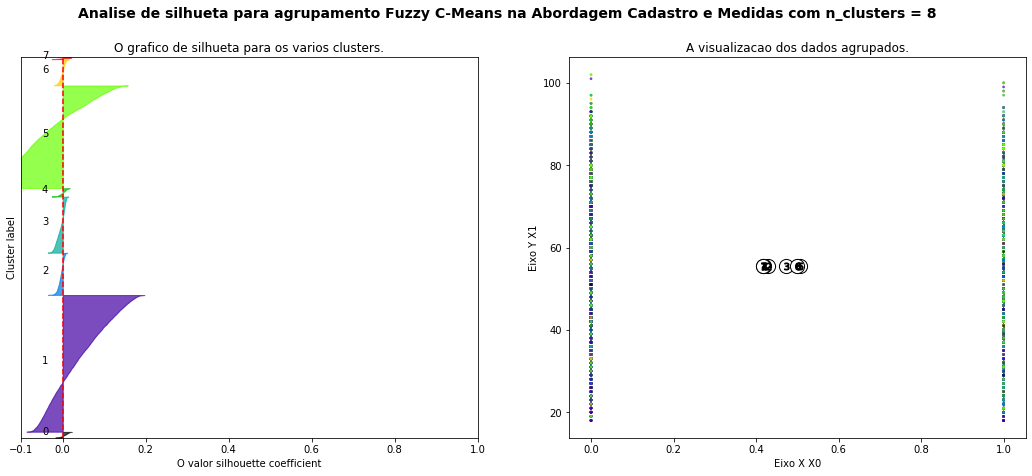

In [24]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(fuzzy_cadastro_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = FCM(n_clusters=n_clusters, random_state=42)
    clusterer.fit(fuzzy_cadastro_array)
    cluster_labels = clusterer.predict(fuzzy_cadastro_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(fuzzy_cadastro_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio para Fuzzy é :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(fuzzy_cadastro_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fuzzy_cadastro_array[:, 0], fuzzy_cadastro_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.centers
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento Fuzzy C-Means na Abordagem Cadastro e Medidas "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_FUZZY / 'graficos' / f'metodosilhouette_fuzzy_cadastro_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando 

In [25]:
#dataset com grupos e com os dados de cadastro e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estaitsticos, 11 doenças em cada grupo 
dataset_com_grupos_cadastro = dataset.loc[:,'numero_identificacao':'altura']
dataset_com_grupos_cadastro['IMC'] = fuzzy_dataset_cadastro['IMC']
dataset_com_grupos_cadastro['grupo'] = fuzzy_grupos_cadastro
dataset_com_grupos_cadastro = pd.concat([dataset_com_grupos_cadastro,dataset.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_com_grupos_cadastro

# Salva dataset com dados completos após o K-Means com abordagem 1 (cadastro e medidas)
dataset_com_grupos_cadastro.to_csv(path_or_buf = DIR_FUZZY / "padrao_doenca" / 'mapa_apos_fuzzy_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

In [26]:
dataset_com_grupos_cadastro.head()

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,grupo,sist 9:00,sist 9:15,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
0,4,1923-10-05,1,94.0,85.0,160,33.2,1,105.0,108.0,...,118.5,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34
1,5,1948-10-07,1,70.0,80.0,165,29.4,1,103.0,114.0,...,106.0,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23
2,6,1999-03-23,1,19.0,100.0,197,25.8,5,147.0,148.0,...,133.0,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,2,140.0,139.0,...,131.0,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9
4,8,1990-03-07,1,28.0,120.0,172,40.6,1,113.0,110.0,...,115.0,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11


## Abordagem 1: Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
#parametro simples do modelo
%time random_forest_fuzzy_cadastro = RandomForestClassifier(n_estimators=50)

Wall time: 0 ns


In [29]:
#base para modelo

In [30]:
Counter(fuzzy_grupos_cadastro)

Counter({1: 6797, 5: 1143, 2: 4992, 4: 2385, 3: 1795, 6: 1916, 7: 122})

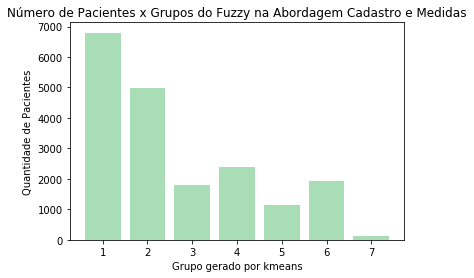

In [31]:
classes = []
qtds = []

contagem = Counter(fuzzy_grupos_cadastro)

for i in range(1,fuzzy_num_otimo_clusters_cadastro + 1):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid ()
plt.title('Número de Pacientes x Grupos do Fuzzy na Abordagem Cadastro e Medidas')
fig = plt.gcf()
fig.savefig(DIR_FUZZY / 'graficos' / 'grafico_Random_fuzzy_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [32]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(fuzzy_cadastro_array, fuzzy_grupos_cadastro, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(fuzzy_cadastro_array, fuzzy_grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [33]:
#treino
random_forest_fuzzy_cadastro.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 1: VALIDAÇÃO

In [34]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_fuzzy_cadastro.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [35]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [36]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,1,2,3,4,5,6,7
1,4079,0,0,0,0,0,0
2,0,3036,0,0,0,0,0
3,0,0,1085,0,0,0,0
4,0,0,0,1392,0,0,0
5,0,0,0,0,699,0,0
6,0,0,0,0,0,1119,0
7,0,0,0,0,0,0,80


#### Abordagem 1: TESTE

In [37]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_fuzzy_cadastro.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [38]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.8274151436031332 - Recall: 0.6259780356473525 - F1 Score: 0.6755509491692033


In [39]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,1,2,3,4,5,6,7
1,2712,0,5,1,0,0,0
2,0,1952,0,0,1,3,0
3,312,0,312,84,0,2,0
4,99,9,80,729,5,71,0
5,0,231,1,18,148,46,0
6,3,117,11,174,19,473,0
7,28,0,2,0,0,0,12


In [40]:
dataset_com_grupos_cadastro.describe()
fuzzy_cadastro_array.shape
fuzzy_cadastro_sem_id

,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,...,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45,grupo
0,1,94.0,33.2,105.0,108.0,116.0,104.0,106.0,98.0,102.0,...,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0,2
1,1,70.0,29.4,103.0,114.0,82.0,104.0,98.0,106.0,108.0,...,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0,2
2,1,19.0,25.8,147.0,148.0,156.0,140.0,130.0,132.0,121.0,...,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0,6
3,0,40.0,24.2,140.0,139.0,142.0,137.0,135.0,177.0,148.0,...,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0,3
4,1,28.0,40.6,113.0,110.0,101.0,108.0,111.0,111.0,114.0,...,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,1,47.0,27.5,163.0,198.0,172.0,148.0,161.0,156.0,156.0,...,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0,3
19146,1,49.0,26.9,114.0,120.0,164.0,116.0,119.0,126.0,123.0,...,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0,3
19147,0,35.0,33.3,107.0,110.0,103.0,105.0,108.0,111.0,114.0,...,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0,2
19148,0,68.0,25.0,94.0,107.0,112.0,124.0,120.0,94.0,102.0,...,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0,2


In [41]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_com_grupos_cadastro, fuzzy_grupos_cadastro, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_com_grupos_cadastro, fuzzy_grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_FUZZY / "padrao_doenca" / 'fuzzy_pacientes_validacao_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_FUZZY / "padrao_doenca" / 'fuzzy_pacientes_teste_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 1: Importância das Features Random Forest

In [42]:
len(fuzzy_ls_cadastro), len(random_forest_fuzzy_cadastro.feature_importances_)

(167, 167)

In [43]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':fuzzy_ls_cadastro,'importance':np.round(random_forest_fuzzy_cadastro.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

#importances.to_excel('diastolica_sistolica/features_sisto_diasto.xlsx')

importancia.to_csv(path_or_buf = DIR_FUZZY / "padrao_doenca" / 'fuzzy_importancia_features_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

,features,importance
47,sist 20:00,0.019
45,sist 19:30,0.017
43,sist 19:00,0.016
52,sist 21:15,0.016
50,sist 20:45,0.016
...,...,...
102,diast 13:15,0.003
128,diast 19:45,0.003
131,diast 20:30,0.003
1,idade,0.002


# Abordagem 2: Medidas como entrada

In [44]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
fuzzi_ls_sist_diast = list(fuzzi_dataset_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

fuzzi_medidas_sem_id = fuzzi_dataset_medidas.loc[:,'sist 9:00':'diast 8:45']

#dados_medidas_sem_id.head(5)
fuzzi_medidas_sem_id.loc[1:70]


,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0
5,152.0,152.0,152.0,152.0,154.0,138.0,137.0,152.0,95.0,117.0,...,67.0,94.0,120.0,109.0,109.0,110.0,111.0,112.0,114.0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,80.0,80.0,85.0,96.0,106.0,105.0,103.0,105.0,104.0,100.0,...,59.0,60.0,61.0,60.0,60.0,55.0,61.0,47.0,49.0,45.0
67,113.0,119.0,120.0,122.0,117.0,122.0,118.0,122.0,126.0,133.0,...,85.0,85.0,85.0,86.0,87.0,62.0,63.0,86.0,81.0,84.0
68,154.0,142.0,123.0,125.0,111.0,113.0,114.0,118.0,113.0,121.0,...,67.0,78.0,89.0,97.0,82.0,87.0,96.0,100.0,83.0,85.0
69,118.0,122.0,116.0,115.0,84.0,102.0,120.0,118.0,116.0,115.0,...,68.0,68.0,67.0,56.0,62.0,66.0,73.0,66.0,72.0,75.0


## Abordagem 2: Número de Clusters gerado pelo wcss k-Means

In [45]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_fuzzi = calculate_wcss(fuzzi_medidas_sem_id)
num_clusters_medidas_fuzzi = optimal_number_of_clusters(sum_of_squares_medidas_fuzzi)
num_clusters_medidas_fuzzi

Wall time: 50.5 s


7

In [46]:
#convertendo os dados para a clusterização

fuzzi_dados_medidas_array = np.array(fuzzi_medidas_sem_id)

In [47]:
# habilitando o Fuzzi kmeans com a qtd de clusters calculado na etapa anterior

fuzzi_medidas = FCM(n_clusters=num_clusters_medidas_fuzzi, random_state=42)
%time fuzzi_medidas.fit(fuzzi_dados_medidas_array)

Wall time: 24.5 s


In [48]:
# dir(fcm)


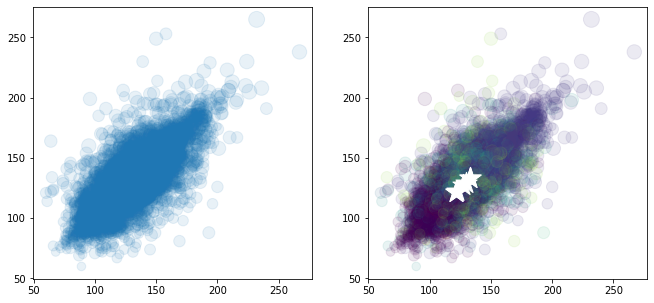

In [49]:
# outputs
fcm_centers = fuzzi_medidas.centers
grupo_medidas_fuzzi = fuzzi_medidas.predict(fuzzi_dados_medidas_array)

# plot result
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(fuzzi_dados_medidas_array[:,0], fuzzi_dados_medidas_array[:,1],fuzzi_dados_medidas_array[:,2],alpha=.1)

axes[1].scatter(fuzzi_dados_medidas_array[:,0], fuzzi_dados_medidas_array[:,1],fuzzi_dados_medidas_array[:,2],c=grupo_medidas_fuzzi, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="*", s=500, c='w')
plt.show()

In [50]:
set(grupo_medidas_fuzzi)

{0, 1, 2, 3, 4, 5, 6}

In [51]:
fuzzi_medidas.centers[6]

array([121.82532956, 122.0692067 , 122.09700807, 122.00785646,
       121.7854377 , 121.63005235, 121.4931799 , 121.34480438,
       121.03554389, 120.89827656, 120.73876534, 120.56902261,
       120.42118187, 120.36138552, 120.08994187, 119.73348542,
       119.14872454, 118.64688169, 118.18877364, 117.75664168,
       117.37514105, 117.29180302, 117.32009614, 117.38445769,
       117.65287302, 117.92195951, 118.23385093, 118.4315331 ,
       118.71217749, 119.20989374, 119.50078148, 119.80500929,
       120.06916248, 120.24509337, 120.46069789, 120.6283101 ,
       120.82093015, 120.99248859, 121.17866761, 121.22366903,
       121.27296999, 121.24542138, 121.40975127, 121.38347652,
       121.25026446, 121.09974304, 120.84679003, 120.68036985,
       120.19941718, 119.75859879, 119.30332723, 118.87825017,
       118.13144577, 117.52936074, 116.75205999, 116.17683477,
       115.24446928, 113.70728658, 112.22349358, 110.98021777,
       110.29932222, 109.86405594, 109.35980778, 109.45

In [52]:
set(grupo_medidas_fuzzi)

{0, 1, 2, 3, 4, 5, 6}

In [53]:
for grupo_contagem in set(grupo_medidas_fuzzi):
    contagem1 = 0
    for grupo_paciente in grupo_medidas_fuzzi:
        if (grupo_paciente == grupo_contagem):
            contagem1 += 1

    print(f'Quantidade de pacientes no cluster {grupo_contagem+1}: {contagem1}')


Quantidade de pacientes no cluster 1: 6683
Quantidade de pacientes no cluster 2: 4969
Quantidade de pacientes no cluster 3: 1916
Quantidade de pacientes no cluster 4: 2488
Quantidade de pacientes no cluster 5: 1077
Quantidade de pacientes no cluster 6: 1880
Quantidade de pacientes no cluster 7: 137


In [54]:
#incluir grupos nos dados de sist e diast

fuzzi_medidas_sem_id['grupo'] = grupo_medidas_fuzzi
fuzzi_medidas_sem_id['grupo'] = fuzzi_medidas_sem_id['grupo'] + 1
fuzzi_medidas_sem_id

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45,grupo
0,105.0,108.0,116.0,104.0,106.0,98.0,102.0,107.0,111.0,116.0,...,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0,1
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0,1
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0,5
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0,2
4,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,163.0,198.0,172.0,148.0,161.0,156.0,156.0,138.0,107.0,76.0,...,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0,2
19146,114.0,120.0,164.0,116.0,119.0,126.0,123.0,122.0,122.0,159.0,...,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0,2
19147,107.0,110.0,103.0,105.0,108.0,111.0,114.0,144.0,128.0,104.0,...,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0,1
19148,94.0,107.0,112.0,124.0,120.0,94.0,102.0,113.0,104.0,96.0,...,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0,1


In [55]:
len(fuzzi_medidas_sem_id.loc[:,'grupo'])
set(fuzzi_medidas_sem_id.loc[:,'grupo'])

{1, 2, 3, 4, 5, 6, 7}

In [56]:
fuzzi_medidas_sem_id.loc[:,'grupo']

0        1
1        1
2        5
3        2
4        1
        ..
19145    2
19146    2
19147    1
19148    1
19149    6
Name: grupo, Length: 19150, dtype: int64

###  Abordagem 2: Método Elbow
####  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
####  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

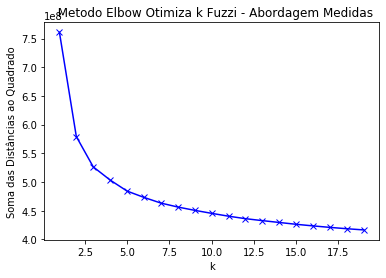

Wall time: 88.3 ms


In [57]:
#metodo de Elbow

Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(fuzzi_dados_medidas_array)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('  Metodo Elbow Otimiza k Fuzzi - Abordagem Medidas')
fig = plt.gcf() 
fig.savefig( DIR_FUZZY / 'graficos' / f'fuzzi_metodoelbow_medida.png', format="png")
%time plt.show()

### Abordagem 2: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.20556068194132648
Para n_clusters = 3 O score_silhouette medio e : 0.12817200383813093
Para n_clusters = 4 O score_silhouette medio e : 0.0828335775668247
Para n_clusters = 5 O score_silhouette medio e : 0.07871120462971788
Para n_clusters = 6 O score_silhouette medio e : 0.06106949271057454
Para n_clusters = 7 O score_silhouette medio e : 0.059065673771412655
Para n_clusters = 8 O score_silhouette medio e : 0.05592367596994815


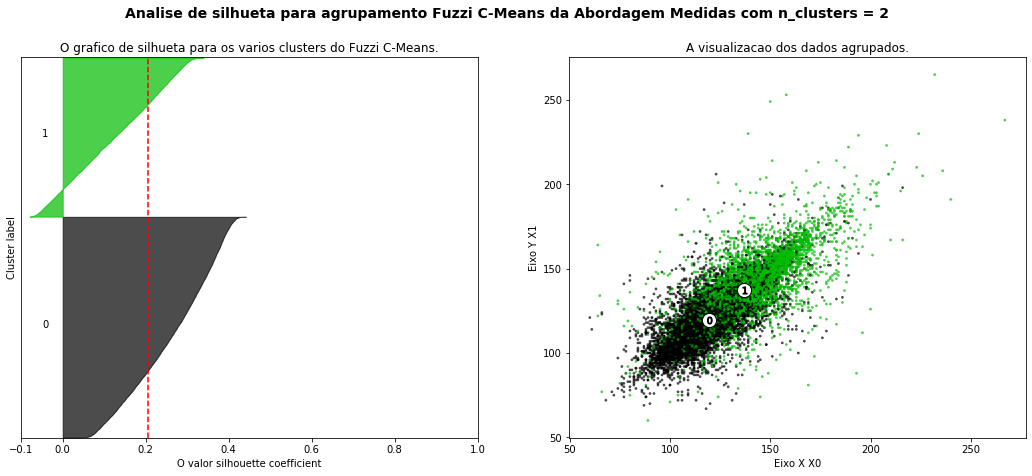

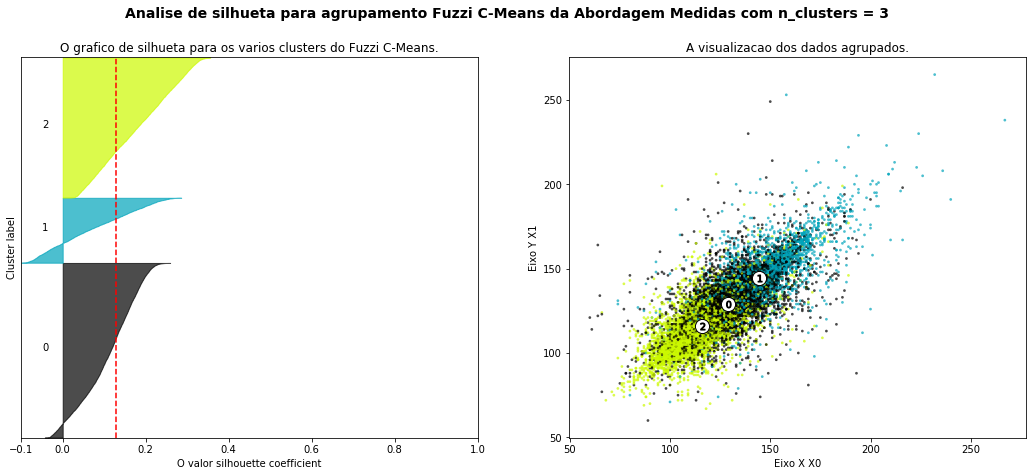

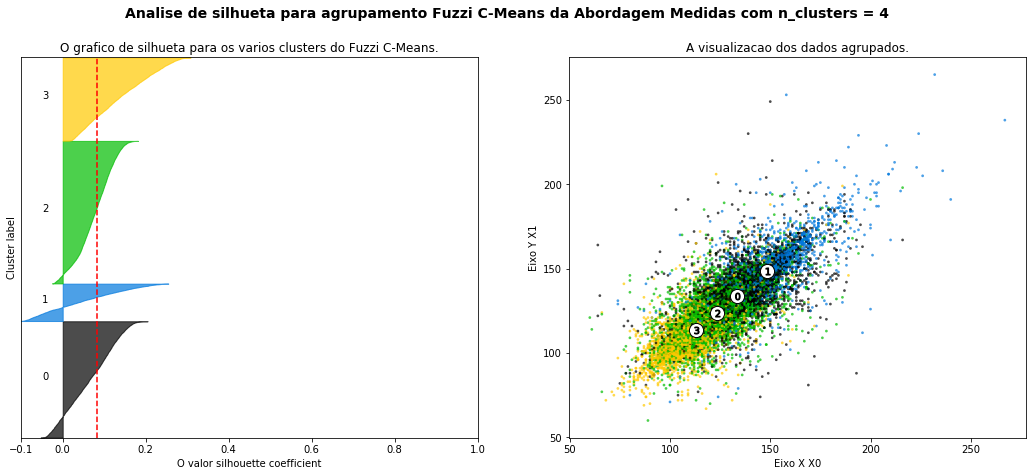

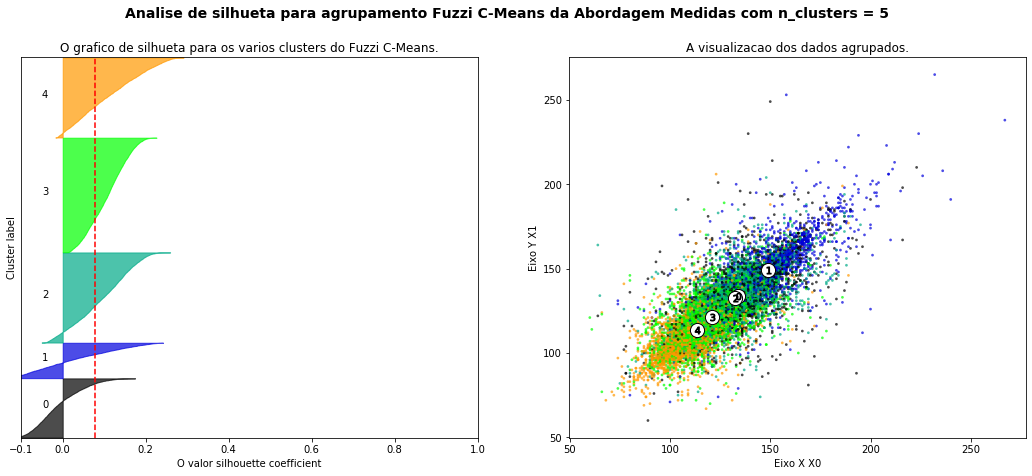

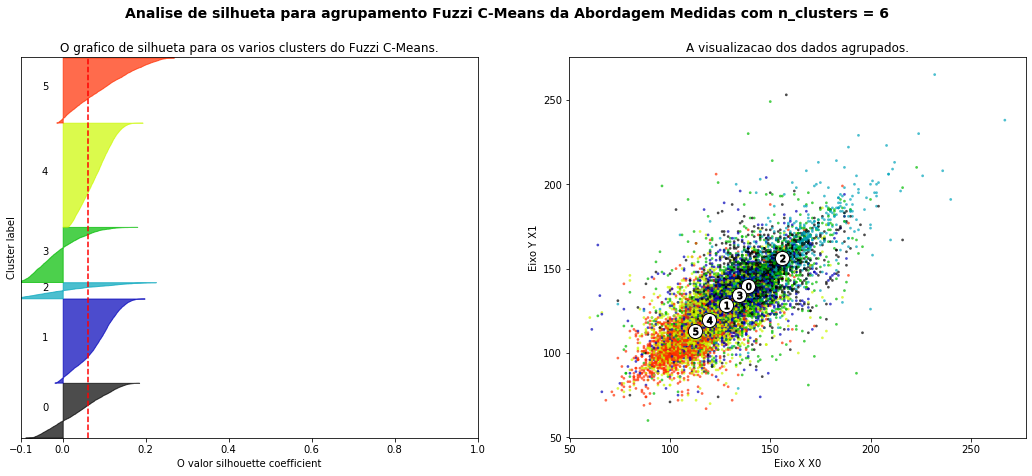

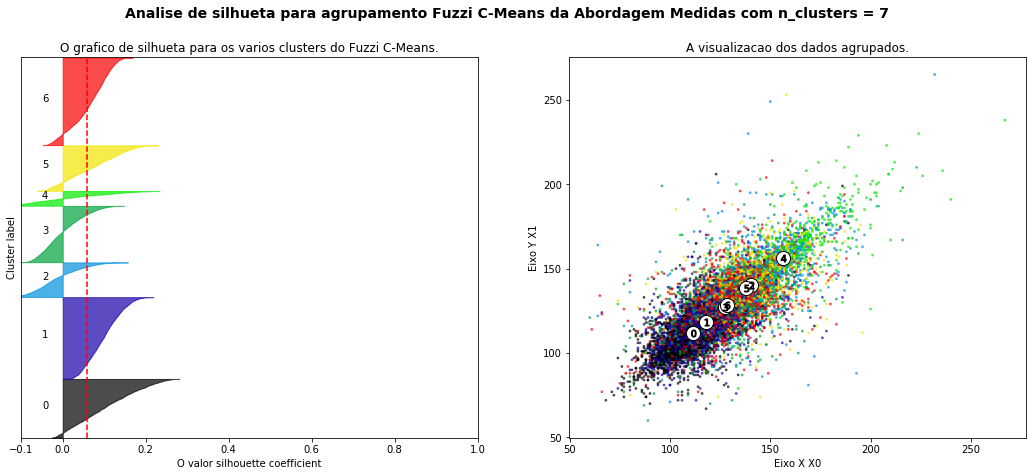

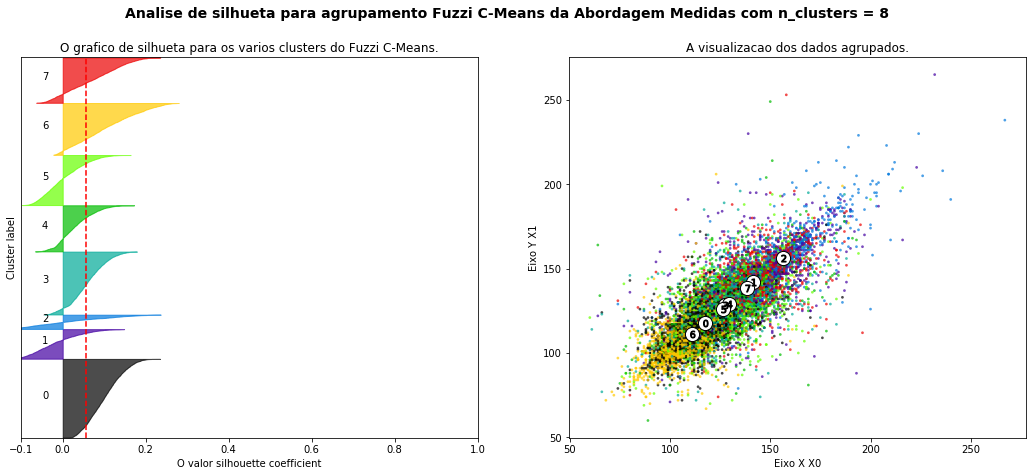

In [58]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(fuzzi_dados_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(fuzzi_dados_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(fuzzi_dados_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(fuzzi_dados_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters do Fuzzi C-Means.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fuzzi_dados_medidas_array[:, 0], fuzzi_dados_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento Fuzzi C-Means da Abordagem Medidas "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_FUZZY / 'graficos' / f'fuzzi_metodosilhouette_medidas_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [59]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupo_medidas_fuzzi)

for i in range(0,num_otimo_clusters_medidas):
    classes.append(i)
    qtds.append(contagem[i])

classes1 = [num + 1 for num in classes]
plt.bar(classes1,qtds,color="#a8ddb5")
plt.xticks(classes1)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Número de Pacientes x Grupos na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_pacientes_GruposK-means_Abordagem2_medidas.svg',format="svg")
plt.show()


NameError: name 'num_otimo_clusters_medidas' is not defined

In [ ]:
contagem1 = 0
grupo_contagem = 0
for i in grupos_medidas:
    if (i == grupo_contagem):
        contagem1 += 1

print(f'Quantidade de pacientes no cluster {grupo_contagem+1}: {contagem1}')


In [ ]:
classes

In [ ]:
set(grupos_medidas)

In [ ]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_medidas_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']

dataset_medidas_apos_kmeans['grupo'] = grupos_medidas
dataset_medidas_apos_kmeans = pd.concat([dataset_medidas_apos_kmeans,
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_medidas_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 2 (medidas)
dataset_medidas_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

In [ ]:
dataset_medidas_apos_kmeans.head()

### Abordagem 2: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#parametro simples do modelo
random_forest_medidas = RandomForestClassifier(n_estimators=50)

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
# 
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [ ]:
#treino
random_forest_medidas.fit(x_train, y_train)

In [ ]:
#dir(random_forest_medidas)

In [ ]:
random_forest_medidas.classes_

#### Abordagem 2: VALIDAÇÃO

In [ ]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_medidas.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [ ]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

#### Abordagem 2: TESTE

In [ ]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_medidas.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [ ]:
x_test

In [ ]:
y_prev_test

In [ ]:
y_test

In [ ]:
y_test == y_prev_test

In [ ]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

In [ ]:
dataset_medidas_apos_kmeans.describe()


In [ ]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
#x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=1 - train_ratio, random_state=42)
#x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')


#### Abordagem 2: Importância das Features Random Forest

In [ ]:
len(ls_sist_diast), len(random_forest_medidas.feature_importances_)

In [ ]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia_medidas = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_medidas.feature_importances_,3)})
importancia_medidas = importancia_medidas.sort_values('importance',ascending=False)

importancia_medidas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia_medidas


In [ ]:
#!pip install lime        # x_train, x_test, y_train, y_test

In [ ]:
#explica = lime_tabular.LimeTabularExplainer(
#                            training_data=np.array(x_train),
#                            feature_names=dados_medidas_sem_id.columns,
#                            #class_names=['grupo 1'],
#                            mode='classification'
#)
#

In [ ]:
#dados_medidas_sem_id.loc[:,'sist 6:45':]

In [ ]:
#exp = explica.explain_instance(
#    data_row=x_test[10], 
#    num_features=20,
#    predict_fn=random_forest_medidas.predict_proba
#)
#
#exp.show_in_notebook(show_table=True)

In [ ]:
 #explica.explain_instance()

In [ ]:
#print (x_test)

In [ ]:
#  Método LIME para explicar como o Classificador Random Forest utilizou as variáveis

#explica = lime_tabular.LimeTabularExplainer(
#                                    dado_treinamento = np.array(x_train),
#                                    nome_colunas = dados_medidas_sem_id.columns,
#                                    nome_classes = 'grupo',
#                                    mode = 'classification'
#                                    )
#
#
#print (explica)

In [ ]:
#print (x_train)

In [ ]:
#print (y_train)

In [ ]:
#print (dados_medidas_array)

# Função para gravar os outputs

In [ ]:
def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)
    true_false_1_0 = {True:1, False:0}
    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_compara_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    if (abordagem == 'medidas'):
        try:
            df_grupo123 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 1) | (todos_dados_grupo['grupo'] == 2) | (todos_dados_grupo['grupo'] == 3)]
            df_grupo123.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo123.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo45 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 4) | (todos_dados_grupo['grupo'] == 5)]
            df_grupo45.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo45.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo67 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 6) | (todos_dados_grupo['grupo'] == 7)]
            df_grupo67.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo67.csv", 
                            sep=";", encoding="latin1", index=False)
        except:
            pass

In [ ]:
#gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

##  Grava arquivo da abordagem 1 - Cadastro e Medidas

In [ ]:
#'def gera_arquivos_por_grupo(todos_dados_grupo):
#'    grupos = list(set(todos_dados_grupo['grupo'].values))
#'    
#'    for grupo in grupos:
#'        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#'        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_cadastro_grupo_{grupo}.csv", 
#'                        sep=";", encoding="latin1", index=False)
#'
#'
#'#gera_arquivos_por_grupo(todos_dados_grupo)

In [ ]:
dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_cadastro = dados_completos_cadastro.replace(genero_M_F)

In [ ]:
gera_arquivos_por_grupo(dados_completos_cadastro,'cadastro')

In [ ]:
dados_completos_cadastro[dados_completos_cadastro['grupo'] == 2]

In [ ]:
#dados_completos_cadastro = dados_completos_generico
#dados_completos_cadastro['grupo'] = dataset_padrao_doenca['grupo']

In [ ]:
#gera_arquivos_por_grupo(dados_completos_cadastro)

##  Grava arquivo da abordagem 2 - Medidas

In [ ]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS /  f"KMEANS_approach_medidas_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [ ]:
dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_medidas_sem_id['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_medidas = dados_completos_medidas.replace(genero_M_F)

In [ ]:
len(dados_completos_medidas)

In [ ]:
#gera_arquivos_por_grupo(dados_completos_medidas)

In [ ]:
gera_arquivos_por_grupo(dados_completos_medidas,'medidas')

In [ ]:
dados_completos_medidas[dados_completos_medidas['grupo'] == 1].describe()